# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
# импорт библиотеки pandas
import pandas as pd 
# импортируем библиотеки для визуализации matplotlib.pyplot, colors
import matplotlib.pyplot as plt
from matplotlib import colors
# импортируем библиотеки для мат.расчетов
import math
import numpy as np
from scipy import stats as st

# чтение файлов с данными с последующим сохранением 
call=pd.read_csv('/datasets/calls.csv')
internet=pd.read_csv('/datasets/internet.csv')
messages=pd.read_csv('/datasets/messages.csv')
tariffs=pd.read_csv('/datasets/tariffs.csv')
users=pd.read_csv('/datasets/users.csv')

С помощью метода info() и head() ознакомимся с данными каждой из таблиц.

In [2]:
print(call.info())
call.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [3]:
print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [4]:
print(messages.info())
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [5]:
print(tariffs.info())
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [6]:
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

## Вывод:

* Мы имеем 5 таблиц, разной длины. 

* Таблица users имеет пустые значения,необходимо посмотреть и проверить можно ли их заполнить.

* Во всех таблица поле отображающее дату, имеет формат object, необходимо преобразовать в формат даты.

* В столбце mb_used таблицы internet содержится информация о трафике в формате float, необходимо округлить значения до целого и поменять формат данных на int. Тоже самое для столбца duration таблицы call. Округление необходимо произвести для расчета потраченных пакетных минут/трафика округляемых сточность 1мин/1Мб.

### Шаг 2. Подготовим данные

Определим порядок действий:
* 2.1 Приведем столбцы с датой к нужным типу datetime64. 
* 2.2 Проверка на наличие дубликатов
* 2.2.1 Переформатирование таблицы users, проверка на наличие дублей среди клиентов.
* 2.2.2 Проверка столбца tariff таблицы users на количество значений
* 2.3 Замена нулевых значений в столбце duration таблицы call.
* 2.4 Замена нулевых значений в столбце mb_used таблицы internet.
* 2.5 Подсчитаем для каждого пользователя величины
* 2.5.1 cделанных звонков и израсходованных минут разговора по месяцам.
* 2.5.2 количество отправленных сообщений по месяцам
* 2.5.3 объем израсходованного интернет-трафика по месяцам
* 2.5.4 помесячную выручку с каждого пользователя

#### 2.1 Приведем столбцы всех таблиц содержащие дату в формате 'object' к формату datetime64.
Для этого напишем функцию column_to_datetime. 

In [7]:
# используем метод to_datetime
def column_to_datetime(table,column):
    table[column] = pd.to_datetime(table[column], format='%Y-%m-%d %H:%M')
    print('Выполнена замена формата данных в таблице столбца',column, 'на "datetime64"')
    return

Применим функцию 'column_to_datetime' к следующим столбцам таблиц:
* call_date таблица call
* session_date таблица internet
* message_date таблица message
* churn_date и reg_date	таблица users

In [8]:
column_to_datetime(call,'call_date')
column_to_datetime(internet,'session_date')
column_to_datetime(messages,'message_date')
column_to_datetime(users,'reg_date')
column_to_datetime(users,'churn_date')

Выполнена замена формата данных в таблице столбца call_date на "datetime64"
Выполнена замена формата данных в таблице столбца session_date на "datetime64"
Выполнена замена формата данных в таблице столбца message_date на "datetime64"
Выполнена замена формата данных в таблице столбца reg_date на "datetime64"
Выполнена замена формата данных в таблице столбца churn_date на "datetime64"


#### 2.2 Проверка на наличие дублей.

In [9]:
# проверим на дубликаты исходные таблицы
def duplicate(table):
    print("Количество дубликатов в таблице:", table.duplicated().sum())

In [10]:
duplicate(call)
duplicate(users)
duplicate(internet)
duplicate(messages)

Количество дубликатов в таблице: 0
Количество дубликатов в таблице: 0
Количество дубликатов в таблице: 0
Количество дубликатов в таблице: 0


#### 2.2.1 Переформатирование таблицы users, проверка на наличие дублей среди клиентов.
По опыту прошлых проектов, знаем, что разный регистр букв и наличие буквы "ё" может давать дубли строк.
Поэтому приведем столбцы имеющие значения в качестве строк к единому формату.
Мы узнаем есть ли дубли среди клиентов.

In [11]:
# замену буквы 'ё' на 'е'
users.loc[:,'city']=users.loc[:,'city'].replace('ё', 'е', regex = True)
users.loc[:,'first_name']=users.loc[:,'first_name'].replace('ё', 'е', regex = True)
users.loc[:,'last_name']=users.loc[:,'last_name'].replace('ё', 'е', regex = True)

In [12]:
#перевод в верхний регистр значений столбца
users['city']=users['city'].str.upper() 
users['first_name']=users['first_name'].str.upper() 
users['last_name']=users['last_name'].str.upper() 

In [13]:
#перевод в верхний регистр значений столбца
check_users=users[['age','city','first_name','last_name','user_id']]
check_users.head()

,age,city,first_name,last_name,user_id
0,52,КРАСНОДАР,РАФАИЛ,ВЕРЕЩАГИН,1000
1,41,МОСКВА,ИВАН,ЕЖОВ,1001
2,59,СТЕРЛИТАМАК,ЕВГЕНИЙ,АБРАМОВИЧ,1002
3,23,МОСКВА,БЕЛЛА,БЕЛЯКОВА,1003
4,68,НОВОКУЗНЕЦК,ТАТЬЯНА,АВДЕЕНКО,1004


In [14]:
# объявляем функцию, с параметрами название словаря, и срез таблицы по которой будет формироватся словарь
def make_dict_for_4_values(name_of_dict,table):
    for i in range(len(table)):
        try:
            # сначала пытаемся добавить к ключу еще одно значение в список
            name_of_dict[str(table.loc[i][0])+'#'+str(table.loc[i][1])+'#'+str(table.loc[i][2])+'#'+str(table.loc[i][3])].append(table.loc[i][4])
        except AttributeError:
        # если ключ,имеет уже значение, то создаем список из значений
            name_of_dict[str(table.loc[i][0])+'#'+str(table.loc[i][1])+'#'+str(table.loc[i][2])+'#'+str(table.loc[i][3])]=([name_of_dict[str(table.loc[i][0])+'#'+str(table.loc[i][1])+'#'+str(table.loc[i][2])+'#'+str(table.loc[i][3])],table.loc[i][4]])
        # ключ со значениями больше одного,добавляем в список many_values_of_keys_4
            many_values_of_keys_4.append(str(table.loc[i][0])+'#'+str(table.loc[i][1])+'#'+str(table.loc[i][2])+'#'+str(table.loc[i][3]))
        # если ключа нет в словаре, создаем первую пару ключ-значение
        except KeyError:
            name_of_dict[str(table.loc[i][0])+'#'+str(table.loc[i][1])+'#'+str(table.loc[i][2])+'#'+str(table.loc[i][3])]=(table.loc[i][4])
    print('Длина словаря:',len(name_of_dict),'\\n','Количество ключей имеющих больше одного значения',len(many_values_of_keys_4))

In [15]:
# объявляем cловарь-справочник
dict_users={}
# объявляем список для ключей имеющих больше одного значения
many_values_of_keys_4=[]
# формируем cловарь используя написаную функцию 
make_dict_for_4_values(dict_users,check_users)

Длина словаря: 500 \n Количество ключей имеющих больше одного значения 0


Все клиенты уникальны.

#### 2.2.2 Проверка столбца tariff таблицы users на количество значений

In [16]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Все в порядке, столбец 'tariff' имеет только да значения.
Проверка дублей завершена, аномалий не найдено.

#### 2.3 Замена нулевых значений в столбце duration таблицы call.

По условию задачи у большого количество звонков длительность — 0.0 минут. Это проблема в данных, предположим, что был сбой в системе, и клиенты немного поговорили, но это не залогировались.  К тому же в детализации обычно не указывают звонки в которых не было соединения, в наших данных соединения есть,значит такие соединения необходимо учитывать.
Также было пояснено, что оплата в тарифе идет за любое соединение нетарифицируемого порога нет.
Необходимо поменять значения 0 на значение, которое сможет быть учтено при подсчете количества расходуемого количества минут  включенного в тариф. Заменим 0 на значение 0.001 при условии, что таких значений не окажется в столбце 'duration',чтобы  навсякий случай хранить информацию у произощедшем сбое.

In [17]:
print('Количество соединений имеющих длительность 0.001 -', len(call.query('duration==0.001')['duration']))

Количество соединений имеющих длительность 0.001 - 0


Произведем замену в столбце 'duration'

In [18]:
index_duration_0=call.query('duration==0').index.tolist()
print('Значений 0 в столбце duration:',len(index_duration_0))
call.loc[index_duration_0, 'duration']=0.001

Значений 0 в столбце duration: 39613


Проверим замену.

In [19]:
print('Количество соединений имеющих нулевую длительность соединения -', len(call.query('duration==0')['duration']))

Количество соединений имеющих нулевую длительность соединения - 0


Замена произведена.

Для расчета количества предоплаченных минут необходимо округлить значения минут в столбце duration до целого числа.

In [20]:
for i in range(len(call['duration'])):
    call['duration'][i]=math.ceil(call['duration'][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Замена произведена успешно.
Поменяем тип данных столбца duration на целочисленный,используем метод astype()

In [21]:
call['duration']=call['duration'].astype('int')

Проверим замену.

In [22]:
call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


Замена произведена успешно.

#### 2.4 Замена нулевых значений в столбце mb_used таблицы internet.

Используем ту же логику и действия, что и в обработке нулевых значений в пункте 2.3

In [23]:
print('Количество соединений имеющих расход трафика равный 0.001 -', len(internet.query('mb_used==0.001')['mb_used']))

Количество соединений имеющих расход трафика равный 0.001 - 0


Произведем замену в столбце 'mb_used'

In [24]:
internet.query('mb_used==0').head()

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000


In [25]:
index_mb_used_0=internet.query('mb_used==0').index.tolist()
print('Значений 0 в столбце mb_used:',len(index_mb_used_0))
internet.loc[index_mb_used_0, 'mb_used']=0.001

Значений 0 в столбце mb_used: 19598


Проверим замену.

In [26]:
print('Количество соединений имеющих нулевой расход трафика -', len(internet.query('mb_used==0')['mb_used']))

Количество соединений имеющих нулевой расход трафика - 0


In [27]:
for i in range(len(internet['mb_used'])):
    internet['mb_used'][i]=math.ceil(internet['mb_used'][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Замена произведена успешно.
Поменяем тип данных столбца duration на целочисленный,используем метод astype()

In [28]:
internet['mb_used']=internet['mb_used'].astype('int')

Проверим замену типа данных для столбца 'mb_used'

In [29]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB


Замена произведена успешно.

#### 2.5 Подсчитаем количество сделанных звонков и израсходованных минут разговора по месяцам.
Для начала добавим столбец месяц в таблицу call с помощью метода dt.month, создадим для этого функцию add_month

In [30]:
# добавляем столбец 'month'
def add_month(table,column):
    table['month'] = table[column].dt.month
    return table


Запустим функцию add_monthс параметрами таблицы call и столбца даты call_date

In [31]:
add_month(call,'call_date')

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,1,1000,7
1,1000_1,2018-08-17,1,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


Добавим в таблицу call столбец 'user_id_month', который будет являться идентификатором клиента и месяца в котором осуществлял звонки. Для этого сделаем функцию make_user_id_month, которая делает контакенацию из двух строчных объектов 'user_id' и 'month'

In [32]:
def make_user_id_month(table):
    table['user_id']=table['user_id'].astype('str')
    table['month']=table['month'].astype('str')
    table['user_id_month']=table['user_id']+table['month']
    return table

In [33]:
# добавляем столбец user_id_month в таблицу call с помощью функции make_user_id_month
make_user_id_month(call)

,id,call_date,duration,user_id,month,user_id_month
0,1000_0,2018-07-25,1,1000,7,10007
1,1000_1,2018-08-17,1,1000,8,10008
2,1000_2,2018-06-11,3,1000,6,10006
3,1000_3,2018-09-21,14,1000,9,10009
4,1000_4,2018-12-15,6,1000,12,100012
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12,149912
202603,1499_216,2018-10-18,19,1499,10,149910
202604,1499_217,2018-11-10,11,1499,11,149911
202605,1499_218,2018-10-06,5,1499,10,149910


Сделаем фукцию, которая будет добавлять столбцы, в которых будет подсчитана количество звонков/трафика/смс и суммарный объем звонков/трафика за месяц.

In [34]:
def info_per_month(table,column):
    try:
        sum_per_month=table.groupby('user_id_month')[column].sum()
        sum_per_month=pd.DataFrame(sum_per_month)
        sum_per_month.rename(columns={column:'sum_of_' + column}, inplace=True)
        table=table.merge(sum_per_month,on='user_id_month')
    except TypeError:
        pass
    count_per_month=table.groupby('user_id_month')[column].count()
    count_per_month=pd.DataFrame(count_per_month)
    count_per_month.rename(columns={column:'count_of_' + column}, inplace=True)
    table=table.merge(count_per_month,on='user_id_month')
    return table

Добавим столбцы количество  и суммарный объем  звонков за месяц в таблицу call с помощью функции info_per_month.

In [35]:
# добавляем столбцы
call=info_per_month(call,'duration')
# выведем несколько строк таблицы
call.head()

,id,call_date,duration,user_id,month,user_id_month,sum_of_duration,count_of_duration
0,1000_0,2018-07-25,1,1000,7,10007,346,47
1,1000_12,2018-07-05,3,1000,7,10007,346,47
2,1000_15,2018-07-27,10,1000,7,10007,346,47
3,1000_25,2018-07-21,15,1000,7,10007,346,47
4,1000_29,2018-07-19,12,1000,7,10007,346,47


Сформируем таблицу summary_of_users в которой будем хранить ежемесячный расход по звонкам/трафику/смс.

In [36]:
summary_of_users=call.groupby('user_id_month')[['sum_of_duration','count_of_duration']].mean()

Выведем несколько строк таблицы.

In [37]:
summary_of_users.head()

,sum_of_duration,count_of_duration
user_id_month,,
100010,363,57
100011,344,43
100012,341,46
10005,164,22
10006,187,43


#### 2.5.2 Подсчитаем количество отправленных сообщений по месяцам
Добавим столбец месяц в таблицу messages с помощью функции add_month

In [38]:
add_month(messages,'message_date')

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


Добавим в таблицу messages столбец user_id_month, с помощью функции make_user_id_month

In [39]:
make_user_id_month(messages)

,id,message_date,user_id,month,user_id_month
0,1000_0,2018-06-27,1000,6,10006
1,1000_1,2018-10-08,1000,10,100010
2,1000_2,2018-08-04,1000,8,10008
3,1000_3,2018-06-16,1000,6,10006
4,1000_4,2018-12-05,1000,12,100012
...,...,...,...,...,...
123031,1499_179,2018-12-12,1499,12,149912
123032,1499_180,2018-09-28,1499,9,14999
123033,1499_181,2018-09-27,1499,9,14999
123034,1499_182,2018-11-15,1499,11,149911


Добавим столбцец количество смс за месяц в таблицу messages с помощью функции info_per_month.

In [40]:
# добавляем столбец с количеством смс, обновляем таблицу
messages=info_per_month(messages,'message_date')
# выведем несколько строк
messages.head()

,id,message_date,user_id,month,user_id_month,count_of_message_date
0,1000_0,2018-06-27,1000,6,10006,60
1,1000_3,2018-06-16,1000,6,10006,60
2,1000_5,2018-06-20,1000,6,10006,60
3,1000_8,2018-06-25,1000,6,10006,60
4,1000_16,2018-06-25,1000,6,10006,60


Переименуем столбец count_of_message_date в count_of_message

In [41]:
messages.rename(columns={'count_of_message_date':'count_of_message'}, inplace=True)
# проверим переименование
messages.tail()

,id,message_date,user_id,month,user_id_month,count_of_message
123031,1499_143,2018-09-27,1499,9,14999,11
123032,1499_162,2018-09-29,1499,9,14999,11
123033,1499_170,2018-09-29,1499,9,14999,11
123034,1499_180,2018-09-28,1499,9,14999,11
123035,1499_181,2018-09-27,1499,9,14999,11


In [42]:
messages.groupby('user_id_month')['count_of_message'].mean()

user_id_month
100010    73
100011    58
100012    70
10005     22
10006     60
          ..
14989     44
149910    48
149911    59
149912    66
14999     11
Name: count_of_message, Length: 2717, dtype: int64

Добавим информацию о количестве смс в таблицу summary_of_users с помощью метода merge

In [43]:
summary_of_users=summary_of_users.merge(messages.groupby('user_id_month')['count_of_message'].mean(),on='user_id_month',how='outer')
summary_of_users.head()

,sum_of_duration,count_of_duration,count_of_message
user_id_month,,,
100010,363.0,57.0,73.0
100011,344.0,43.0,58.0
100012,341.0,46.0,70.0
10005,164.0,22.0,22.0
10006,187.0,43.0,60.0


#### 2.5.3 Подсчитаем объем израсходованного интернет-трафика по месяцам
Добавим столбец месяц в таблицу internet с помощью функции add_month

In [ ]:
add_month(internet,'session_date')

Добавим в таблицу internet столбец user_id_month, с помощью функции make_user_id_month

In [45]:
make_user_id_month(internet)

,id,mb_used,session_date,user_id,month,user_id_month
0,1000_0,113,2018-11-25,1000,11,100011
1,1000_1,1053,2018-09-07,1000,9,10009
2,1000_2,1198,2018-06-25,1000,6,10006
3,1000_3,551,2018-08-22,1000,8,10008
4,1000_4,303,2018-09-24,1000,9,10009
...,...,...,...,...,...,...
149391,1499_152,319,2018-10-03,1499,10,149910
149392,1499_153,491,2018-12-14,1499,12,149912
149393,1499_154,1,2018-10-27,1499,10,149910
149394,1499_155,1247,2018-11-26,1499,11,149911


In [46]:
internet=info_per_month(internet,'mb_used')
internet.head()

,id,mb_used,session_date,user_id,month,user_id_month,sum_of_mb_used,count_of_mb_used
0,1000_0,113,2018-11-25,1000,11,100011,14769,24
1,1000_18,659,2018-11-01,1000,11,100011,14769,24
2,1000_19,453,2018-11-28,1000,11,100011,14769,24
3,1000_26,952,2018-11-06,1000,11,100011,14769,24
4,1000_29,623,2018-11-15,1000,11,100011,14769,24


Переименуем столбец count_of_mb_used в count_of_sessions

In [47]:
internet.rename(columns={'count_of_mb_used':'count_of_sessions'}, inplace=True)
# проверим переименование
internet.tail()

,id,mb_used,session_date,user_id,month,user_id_month,sum_of_mb_used,count_of_sessions
149391,1499_10,1,2018-09-29,1499,9,14999,1849,5
149392,1499_58,7,2018-09-28,1499,9,14999,1849,5
149393,1499_98,1139,2018-09-29,1499,9,14999,1849,5
149394,1499_112,340,2018-09-29,1499,9,14999,1849,5
149395,1499_135,362,2018-09-30,1499,9,14999,1849,5


Добавим информацию о количестве расходуемого трафика и сессий в таблицу summary_of_users с помощью метода merge

In [48]:
summary_of_users=summary_of_users.merge(internet.groupby('user_id_month')[['sum_of_mb_used','count_of_sessions']].mean(),on='user_id_month',how='outer')
# проверим добавление
summary_of_users.head()

,sum_of_duration,count_of_duration,count_of_message,sum_of_mb_used,count_of_sessions
user_id_month,,,,,
100010,363.0,57.0,73.0,14717.0,27.0
100011,344.0,43.0,58.0,14769.0,24.0
100012,341.0,46.0,70.0,9829.0,21.0
10005,164.0,22.0,22.0,2257.0,5.0
10006,187.0,43.0,60.0,23262.0,49.0


При складывании таблиц у нас могли появится пропуски у клиентов,которые могли использовать только часть услуг пакета. 
Например,только звонки и интернет без смс. Проверим это с помощью метода isnull().sum()

In [49]:
summary_of_users.isnull().sum()

sum_of_duration       40
count_of_duration     40
count_of_message     497
sum_of_mb_used        11
count_of_sessions     11
dtype: int64

Гипотеза подтвердилась, заполним 0 пустые строки с помощью метода fillna()

In [50]:
summary_of_users = summary_of_users.fillna(0)

Чтобы неперегружать таблицу, сделаем краткую версию таблицы summary_of_users без столбцов количество звонков и сессий выхода в интернет,сохраним её в переменную summary_of_users_short.

In [51]:
summary_of_users_short=summary_of_users
del summary_of_users_short['count_of_duration']
del summary_of_users_short['count_of_sessions']
summary_of_users_short.head()

,sum_of_duration,count_of_message,sum_of_mb_used
user_id_month,,,
100010,363.0,73.0,14717.0
100011,344.0,58.0,14769.0
100012,341.0,70.0,9829.0
10005,164.0,22.0,2257.0
10006,187.0,60.0,23262.0


#### 2.5.4 Подсчитаем помесячную выручку с каждого пользователя
Чтобы расчитать помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [52]:
# добавим в таблиц summary_of_users_short столбцы over_call, over_mb, over_sms
summary_of_users_short['over_call']=0
summary_of_users_short['over_mb']=0
summary_of_users_short['over_sms']=0
summary_of_users_short['revenue']=0
summary_of_users_short['tariff']=''
summary_of_users_short['user_id']=0

In [53]:
# проверим добавление столбцов.
summary_of_users_short.head()

,sum_of_duration,count_of_message,sum_of_mb_used,over_call,over_mb,over_sms,revenue,tariff,user_id
user_id_month,,,,,,,,,
100010,363.0,73.0,14717.0,0,0,0,0,,0
100011,344.0,58.0,14769.0,0,0,0,0,,0
100012,341.0,70.0,9829.0,0,0,0,0,,0
10005,164.0,22.0,2257.0,0,0,0,0,,0
10006,187.0,60.0,23262.0,0,0,0,0,,0


In [54]:
# перенесем индексы с user_id_month в столбец 'user_id_month'
summary_of_users_short['user_id_month']=summary_of_users_short.index.tolist()

In [55]:
# для удобства выведем таблицу tariffs
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Запустим построчный цикл для расчета выручки по каждому из клиентов.

In [56]:
for i in range(len(summary_of_users_short)):
    # в переменной key храним извлеченый user_id из сцепки с месяцем
    key=int(summary_of_users_short['user_id_month'][i][:4])
    # записваем в столбец 'user_id'
    summary_of_users_short['user_id'][i]=key
    if 'smart' in list(users.query('user_id==@key')['tariff']):
        # обращаемся в таблицу tariffs по названию тарифа, зная что индекс у тарифа СМАРТ - 0
        summary_of_users_short['tariff'][i]=tariffs['tariff_name'][0]
        # записываем разницу в звонках с количеством минут в пакете в столбец 'over_call'
        summary_of_users_short['over_call'][i]=summary_of_users_short['sum_of_duration'][i]-tariffs['minutes_included'][0]
        # добавляем условие, если не было превышение пакета, то записываем 0 в столбец over_call
        if summary_of_users_short['over_call'][i]<0:
            summary_of_users_short['over_call'][i]=0
        # записываем разницу в расходе трафика с пакетным трафиком в столбец 'over_mb'
        summary_of_users_short['over_mb'][i]=summary_of_users_short['sum_of_mb_used'][i]-tariffs['mg_per_month_included'][0]
         # добавляем условие, если не было превышение пакета, то записываем 0 в столбец 'over_mb'
        if summary_of_users_short['over_mb'][i]<0:
            summary_of_users_short['over_mb'][i]=0
        # записываем разницу в кол-ве смс с пакетом смс в столбец 'over_sms'
        summary_of_users_short['over_sms'][i]=summary_of_users_short['count_of_message'][i]-tariffs['messages_included'][0]
         # добавляем условие, если не было превышение пакета, то записываем 0 в столбец 'over_sms'
        if summary_of_users_short['over_sms'][i]<0:
            summary_of_users_short['over_sms'][i]=0
        # считаем выручку базовая стоимостьпакета + перемноженный перерасход в соответствии с тарифом
        summary_of_users_short['revenue'][i]=tariffs['rub_monthly_fee'][0]+(
            math.ceil(summary_of_users_short['over_mb'][i]/1000)*tariffs['rub_per_gb'][0]+
            summary_of_users_short['over_sms'][i]*tariffs['rub_per_message'][0]
        )
    else:
        # те же самые действия для пакета ultra, только для подтягивания значений из tariffs строка с индексом 1 
        summary_of_users_short['tariff'][i]=tariffs['tariff_name'][1]
        summary_of_users_short['over_call'][i]=summary_of_users_short['sum_of_duration'][i]-tariffs['minutes_included'][1]
        if summary_of_users_short['over_call'][i]<0:
            summary_of_users_short['over_call'][i]=0
        summary_of_users_short['over_mb'][i]=summary_of_users_short['sum_of_mb_used'][i]-tariffs['mg_per_month_included'][1]
        if summary_of_users_short['over_mb'][i]<0:
            summary_of_users_short['over_mb'][i]=0
        summary_of_users_short['over_sms'][i]=summary_of_users_short['count_of_message'][i]-tariffs['messages_included'][1]
        if summary_of_users_short['over_sms'][i]<0:
            summary_of_users_short['over_sms'][i]=0
        summary_of_users_short['revenue'][i]=tariffs['rub_monthly_fee'][1]+(
            math.ceil(summary_of_users_short['over_mb'][i]/1000)*tariffs['rub_per_gb'][1]+
            summary_of_users_short['over_sms'][i]*tariffs['rub_per_message'][1]
        )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to

In [57]:
# проверим заполнение
summary_of_users_short.tail()

,sum_of_duration,count_of_message,sum_of_mb_used,over_call,over_mb,over_sms,revenue,tariff,user_id,user_id_month
user_id_month,,,,,,,,,,
148911,0.0,20.0,17526.0,0,2166,0,1150,smart,1489,148911
148912,0.0,35.0,17349.0,0,1989,0,950,smart,1489,148912
14898,0.0,17.0,11072.0,0,0,0,550,smart,1489,14898
14899,0.0,32.0,17246.0,0,1886,0,950,smart,1489,14899
14764,0.0,0.0,531.0,0,0,0,1950,ultra,1476,14764


Сделаем функцию info_of_client для вывода информации по расходу и выручки длякаждого клиента.

In [58]:
dict_of_month={1:'январе',2:'феврале',3:'марте',4:'апреле',5:'мае',6:'июне',7:'июле',8:'августе',9:'сентябре',10:'октябре',11:'ноябре',12:'декабре'}
# функция получения данных о клиенте за месяц
def info_of_client(id_client,month):
    klient=str(id_client)
    index=users.query('user_id == @klient')['user_id'].index.tolist()
    print('Клиент:', users.loc[index[0],'last_name'], users.loc[index[0],'first_name'],'Тариф:', users.loc[index[0],'tariff'])
    query=str(id_client)+str(month)
    print('Потратил в',dict_of_month[month],'месяце:',summary_of_users_short.loc[query,'revenue'],'рублей','\n')
    print('Количество израсходованных минут:',summary_of_users_short.loc[query,'sum_of_duration'])
    if summary_of_users_short.loc[query,'over_call']>0:
        print('Количество израсходованных минут сверх пакета:',summary_of_users_short.loc[query,'over_call'],'\n')
    print('Количество отправленных СМС:',summary_of_users_short.loc[query,'count_of_message'])
    if summary_of_users_short.loc[query,'over_sms']>0:
        print('Количество отправленных СМС сверх пакета:',summary_of_users_short.loc[query,'over_sms'],'\n')
    print('Количество израсходованного трафика:',summary_of_users_short.loc[query,'sum_of_mb_used'],'Мб') 
    if summary_of_users_short.loc[query,'over_mb']>0:
        print('Количество израсходованного трафика сверх пакета:',summary_of_users_short.loc[query,'over_mb'],'Мб')

Выведем пару примеров работы функции.

In [59]:
info_of_client(1497,11)

Клиент: АГЕЕВА КАРОЛИНА Тариф: smart
Потратил в ноябре месяце: 550 рублей 

Количество израсходованных минут: 387.0
Количество отправленных СМС: 14.0
Количество израсходованного трафика: 14180.0 Мб


In [60]:
info_of_client(1496,12)

Клиент: БЛОХИН ТРИФОН Тариф: smart
Потратил в декабре месяце: 1753 рублей 

Количество израсходованных минут: 533.0
Количество израсходованных минут сверх пакета: 33 

Количество отправленных СМС: 51.0
Количество отправленных СМС сверх пакета: 1 

Количество израсходованного трафика: 20770.0 Мб
Количество израсходованного трафика сверх пакета: 5410 Мб


## Вывод:

#### Мы сделали функционал, который позволяет получить информацию по любому клиенту в разрезе месяца. Можно автоматизировать данный функционал для рассылки персональных предложений по смс, для клиентов которые тратят сверх пакета.

### Шаг 3. Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### 3.1 Статистика величин по каждому из тарифов.
Исследуем по каждому из тарифов средние значения, дисперсию и стандартное отклонение минут разговора, сколько сообщений и какой объём интернет-трафика израсходован. 
Сформируем функцию print_parametrs, в которой используем метод describe() для получения необходимых данных.

In [61]:
def print_parametrs(tariff_name):
    var=tariff_name
    table=summary_of_users_short.query('tariff==@var')[['sum_of_duration','count_of_message','sum_of_mb_used','revenue']].describe()
    print('Статистика по тарифу:',var)
    print('Клиенты в среднем тратят: минут -',math.ceil(table['sum_of_duration']['mean']),'смс -',math.ceil(table['count_of_message']['mean']),'трафика-',math.ceil(table['sum_of_mb_used']['mean']),'Mb')
    print('Стандартное отклонение составляет: в минутах -',math.ceil(table['sum_of_duration']['std']),'смс -',math.ceil(table['count_of_message']['std']),'трафика-',math.ceil(table['sum_of_mb_used']['std']),'Mb')
    print('Дисперсия составляет: по минутам -',math.ceil(table['sum_of_duration']['std']**2),'смс -',math.ceil(table['count_of_message']['std']**2),'трафика-',math.ceil(table['sum_of_mb_used']['std']**2),'Mb')
    print('Средняя выручка:',math.ceil(table['revenue']['mean']), 'руб. медианное значение выручки:',math.ceil(table['revenue']['50%']),'руб.')

In [62]:
# вызовем функцию по тарифу ultra 
print_parametrs("ultra")

Статистика по тарифу: ultra
Клиенты в среднем тратят: минут - 541 смс - 50 трафика- 19489 Mb
Стандартное отклонение составляет: в минутах - 326 смс - 48 трафика- 10098 Mb
Дисперсия составляет: по минутам - 106106 смс - 2286 трафика- 101951581 Mb
Средняя выручка: 2074 руб. медианное значение выручки: 1950 руб.


In [63]:
# вызовем функцию по тарифу smart 
print_parametrs("smart")

Статистика по тарифу: smart
Клиенты в среднем тратят: минут - 430 смс - 34 трафика- 16238 Mb
Стандартное отклонение составляет: в минутах - 195 смс - 29 трафика- 5880 Mb
Дисперсия составляет: по минутам - 37975 смс - 797 трафика- 34571992 Mb
Средняя выручка: 1182 руб. медианное значение выручки: 950 руб.


##### Средняя выручка по тарифу СМАРТ: 1182 руб. медианное значение выручки: 950 руб, это в два раза больше, чем стоит сам пакет!!

### 3.2 Статистика величин по каждому из клиентов.
Сделаем функцию print_parametrs_for_user.

In [64]:
def print_parametrs_for_user(client):
    var=client
    table=summary_of_users_short.query('user_id==@var')[['sum_of_duration','count_of_message','sum_of_mb_used','revenue']].describe()
    index=users.query('user_id == @var')['user_id'].index.tolist()
    print('Клиент:', users.loc[index[0],'last_name'], users.loc[index[0],'first_name'],'User_ID:',var,'Тариф:', users.loc[index[0],'tariff'])
    print('Клиент в среднем тратит: минут -',math.ceil(table['sum_of_duration']['mean']),'смс -',math.ceil(table['count_of_message']['mean']),'трафика-',math.ceil(table['sum_of_mb_used']['mean']),'Mb')
    print('Стандартное отклонение составляет: в минутах -',math.ceil(table['sum_of_duration']['std']),'смс -',math.ceil(table['count_of_message']['std']),'трафика-',math.ceil(table['sum_of_mb_used']['std']),'Mb')
    print('Дисперсия составляет: по минутам -',math.ceil(table['sum_of_duration']['std']**2),'смс -',math.ceil(table['count_of_message']['std']**2),'трафика-',math.ceil(table['sum_of_mb_used']['std']**2),'Mb')
    print('Средняя выручка:',math.ceil(table['revenue']['mean']), 'руб.' )

In [65]:
print_parametrs_for_user(1400)

Клиент: АРТЕМОВ РЕНАТ User_ID: 1400 Тариф: smart
Клиент в среднем тратит: минут - 492 смс - 48 трафика- 20141 Mb
Стандартное отклонение составляет: в минутах - 177 смс - 23 трафика- 7644 Mb
Дисперсия составляет: по минутам - 31195 смс - 495 трафика- 58425899 Mb
Средняя выручка: 1929 руб.


### 3.3 Построим гистограммы по каждому из параметров пакета «Ультра» и «Смарт».

### 3.3.1 Построим гистограмму по объему потраченных минут в соответствии с тарифом.

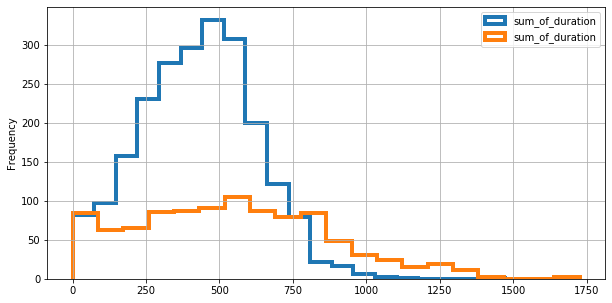

In [66]:
summary_of_users_short.query('tariff=="smart"')['sum_of_duration'].plot(bins=20,kind='hist',histtype='step',linewidth=4,figsize=(10,5),legend=True)
summary_of_users_short.query('tariff=="ultra"')['sum_of_duration'].plot(bins=20,kind='hist',histtype='step',linewidth=4,figsize=(10,5),grid=True,legend=True)

* 1.Наглядно, что половине клиентов по тарифу Смарт не хватает пакета минут.Пока на этом оператор неплохо зарабатывает.
* 2.В пакете Ультра нет ни одного клиента, который бы "выговорил" весь пакет. Основной массе клиентов хватило бы пакета в 1300 минут.

Отобразим сказанное для клиентов тарифа СМАРТ в цифрах.

In [67]:
print(((summary_of_users_short.query('tariff=="smart" & over_call>0')['user_id_month'].count()/summary_of_users_short.query('tariff=="smart"')['user_id_month'].count())*100).round(1),"% клиентов тарифа СМАРТ не хватает пакета минут")

36.4 % клиентов тарифа СМАРТ не хватает пакета минут


### 3.3.2 Построим гистограмму по объему трафика в соответствии с тарифом.

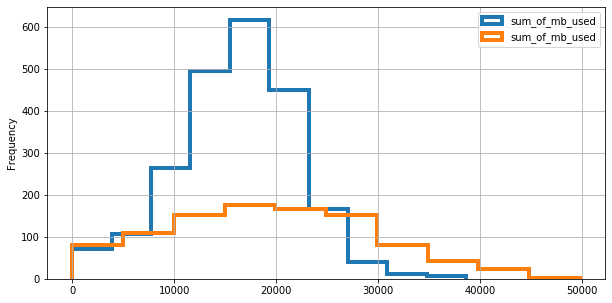

In [68]:
summary_of_users_short.query('tariff=="smart"')['sum_of_mb_used'].plot(bins=10,kind='hist',histtype='step',linewidth=4,figsize=(10,5),legend=True)
summary_of_users_short.query('tariff=="ultra"')['sum_of_mb_used'].plot(bins=10,kind='hist',histtype='step',linewidth=4,figsize=(10,5),grid=True,legend=True)

* 1.Наглядно, что почти половине клиентов по тарифу Смарт не хватает пакета интернета. Часть клиентов может превысить пакетный  расход трафика вдвое.
* 2.Примерно треть клиентов тарифа Ультра нуждаются в дополнительных гигабайтах

Теперь в цифрах.

In [69]:
print(((summary_of_users_short.query('tariff=="smart" & over_mb>0')['user_id_month'].count()/summary_of_users_short.query('tariff=="smart"')['user_id_month'].count())*100).round(1),"% клиентов тарифа СМАРТ не хватает пакета интернета")

58.8 % клиентов тарифа СМАРТ не хватает пакета интернета


In [70]:
print(((summary_of_users_short.query('tariff=="ultra" & over_mb>0')['user_id_month'].count()/summary_of_users_short.query('tariff=="ultra"')['user_id_month'].count())*100).round(1),"% клиентов тарифа УЛЬТРА не хватает пакета интернета")

13.6 % клиентов тарифа УЛЬТРА не хватает пакета интернета


### 3.3.3 Построим гистограмму по объему потраченных смс в соответствии с тарифом.

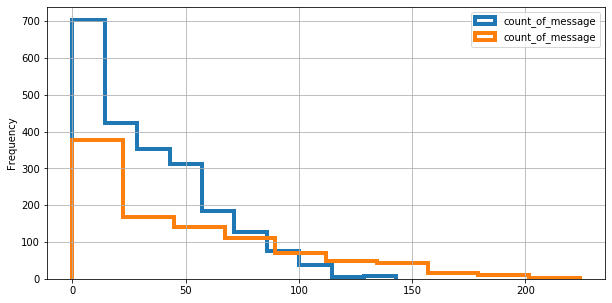

In [71]:
summary_of_users_short.query('tariff=="smart"')['count_of_message'].plot(bins=10,kind='hist',histtype='step',linewidth=4,figsize=(10,5),legend=True)
summary_of_users_short.query('tariff=="ultra"')['count_of_message'].plot(bins=10,kind='hist',histtype='step',linewidth=4,figsize=(10,5),grid=True,legend=True)

Казалось бы, СМС - это прошлый век в эпоху мессенджеров, но клиенты продолжают ими пользоваться.
* 1. Клиенты тарифа Смарт по прежнему переплачивают за допополнительные смс.
* 2. Клиентам тарифа Ультра хватило бы пакета в 300 смс, но маркетинг есть маркетинг. Пока люди клюют на удочку больших цифр, этим надо пользоватся.

In [72]:
print(((summary_of_users_short.query('tariff=="smart" & over_sms>0')['user_id_month'].count()/summary_of_users_short.query('tariff=="smart"')['user_id_month'].count())*100).round(1),"% клиентов тарифа СМАРТ не хватает пакета СМС")

25.3 % клиентов тарифа СМАРТ не хватает пакета СМС


### 3.3.4 Попробуем найти закономерности у клиентов, которые прекратили пользоватся тарифом.
Найдем этих клиентов из таблицы users по столбцу churn_date.

In [73]:
outflow_users=users.query('churn_date.notnull()')['user_id']

Подсчитаем отток клиентов.

In [74]:
print('Отток клиентов по данной выборке за 2018 составил:',len(outflow_users)/len(users)*100,'%')

Отток клиентов по данной выборке за 2018 составил: 7.6 %


Я пока не сотрудник «Мегалайн», но считаю, что отток в 7.6 % в год серьезной цифрой. Не знаю насколько выборка по клиентам репрезентативна, но это большой "звонок" для поиска проблем.

Рассчитаем отток клиентов для каждого из тарифов. 
Для начала определим количество клиентов из выборки для каждого из тарифов.

In [75]:
users_of_ultra=users.query('tariff=="ultra"')['tariff'].count()
users_of_smart=users.query('tariff=="smart"')['tariff'].count()
print('Количество клиентов подключенных к тарифу ultra:',users_of_ultra)
print('Количество клиентов подключенных к тарифу smart:',users_of_smart)

Количество клиентов подключенных к тарифу ultra: 149
Количество клиентов подключенных к тарифу smart: 351


In [76]:
outflow_users_smart=users.query('user_id in @outflow_users & tariff=="smart"')['user_id']
outflow_users_ultra=users.query('user_id in @outflow_users & tariff=="ultra"')['user_id']
print('Отток клиентов по данной выборке за 2018 по тарифу СМАРТ составил:',(len(outflow_users_smart)/users_of_smart*100).round(1),'%')
print('Отток клиентов по данной выборке за 2018 по тарифу УЛЬТРА составил:',(len(outflow_users_ultra)/users_of_ultra*100).round(1),'%')

Отток клиентов по данной выборке за 2018 по тарифу СМАРТ составил: 6.6 %
Отток клиентов по данной выборке за 2018 по тарифу УЛЬТРА составил: 10.1 %


6,6% сбежали с тарифа СМАРТ, явно что-то с ним не так, попробуем отследить причину. 
Гипотеза 1. Овертрафик.
Гипотеза 2. Пакет слишком велик для клиентов.

In [77]:
summary_of_users_short.query('user_id in @outflow_users_smart')[['sum_of_duration','over_call','count_of_message','over_sms','sum_of_mb_used','over_mb']].describe()

,sum_of_duration,over_call,count_of_message,over_sms,sum_of_mb_used,over_mb
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,335.072072,9.576577,29.495495,3.108108,14990.900901,2432.909910
std,148.100808,34.119456,23.591552,9.891550,6408.826287,3388.439717
min,18.000000,0.000000,0.000000,0.000000,1162.000000,0.000000
25%,227.500000,0.000000,12.500000,0.000000,9454.500000,0.000000
50%,342.000000,0.000000,26.000000,0.000000,15312.000000,0.000000
75%,430.000000,0.000000,43.000000,0.000000,19906.000000,4546.000000
max,748.000000,248.000000,106.000000,56.000000,28687.000000,13327.000000


Отток клиентов в тарифе СМАРТ говорит о том, что люди не выговаривают пакет. Необходимо ввести пакет ценовой категории ниже,чем СМАРТ. Например СМАРТ ЛАЙТ всего 400руб и у вас - 350минут 20смс 10Гб. 

10.1 % сбежали с тарифа Ультра, сделаем анализ.

In [78]:
summary_of_users_short.query('user_id in @outflow_users_ultra')[['sum_of_duration','over_call','count_of_message','over_sms','sum_of_mb_used','over_mb']].describe()

,sum_of_duration,over_call,count_of_message,over_sms,sum_of_mb_used,over_mb
count,76.000000,76.0,76.000000,76.0,76.000000,76.000000
mean,475.407895,0.0,27.171053,0.0,18030.605263,1018.302632
std,281.788440,0.0,33.863014,0.0,11262.016204,2983.448868
min,13.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,268.750000,0.0,0.000000,0.0,9957.000000,0.000000
50%,438.000000,0.0,11.000000,0.0,18110.000000,0.000000
75%,731.000000,0.0,44.250000,0.0,23577.750000,0.000000
max,1109.000000,0.0,117.000000,0.0,45226.000000,14506.000000


Отток клиентов в тарифе УЛЬТРА говорит о том, что люди не выговаривают пакет. Необходимо ввести пакет ценовой категории ниже,чем УЛЬТРА. Например СМАРТ ХЛ.
10.1 % сбежали с тарифа Ультра, сделаем анализ.

## Вывод:

#### Клиенты компании «Мегалайн» позволяют хорошо зарабатывать на переплатах тарифа СМАРТ. На графиках мы проанализировали явные провалы в пакете минут, интернет трафика и даже смс  для данного тарифа.

#### Пока клиенты лояльны к нам, мы зарабатывает, но придет час и случится глобальный отток клиентов, которых возможно будет не вернуть в условиях жесточайшей конкуренции операторов связи.

#### Неоходимы срочные меры по внедрению нового пакетного тарифа, в котором будет учтен ооток клиентов, которые не выговаривают тариф.  СМАРТ ЛАЙТ всего 400руб и у вас - 350минут 20смс 10Гб. СМАРТ ЛАЙТ позволит также зарабатывать на переплате за интернет трафик, пока клиенты готовы платить.

#### Также необходимо проработать потребности клиентов пакетов СМАРТ. При формировании нового пакета СМАРТ ХЛ, обратить внимание на цифры:
#### * 58.8 % клиентов тарифа СМАРТ не хватает пакета интернета
#### * 36.4 % клиентов тарифа СМАРТ не хватает пакета минут
#### * 25.3 % клиентов тарифа СМАРТ не хватает пакета СМС


#### По тарифу Ультра заметен перерасход трафика по интернету  у 1/3клиентов. В условиях высокой конкуренции среди операторов, цена в 1950руб. должна подразумевать удовлетворение всех потребностей клиентов данного тарифа. Необходимо увеличить планку пакета интернета до 50Гб.


### Шаг 4. Проверьте гипотезы
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
Пороговое значение alpha задайте самостоятельно.
Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

### 4.1 Проверим гипотезу, что средняя выручка клиентов тарифов «Ультра» и «Смарт» различается.


Проверим гипотезу, что средняя выручка клиентов тарифов «Ультра» и «Смарт» различается. 

Для проверки гипотезы о равенстве среднего генеральной совокупности некоторому значению используется метод (Стьюдента) для это в Python есть библиотека scipy импортировав которую можно провести данный тест scipy.stats.ttest_1samp (array, popmean).
Для проведения данного теста необходимо выбрать уровень значимости.
Уровень значимости — это суммарная вероятность того, что измеренное эмпирически значение окажется далеко от среднего. Выберем уровень значимости — 1%. Если наблюдаемое на выборке значение попадает в эту зону, вероятность такого события при верной нулевой гипотезе признаётся слишком малым (это определяется уровнем значимости). Следовательно, у нас есть основание отвергнуть нулевую гипотезу.

Создамим функцию make_ttest.

In [79]:
def make_ttest(array,mean,alpha):
    alph = alpha # критический уровень статистической значимости
    results = st.ttest_1samp(
        array, 
        mean)
    print('p-значение: ', results.pvalue)
    if (results.pvalue < alph):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Рассчитаем величину среднего mean_revenue_of_smart и сохраним массив по которому удем проводить исследование в переменную array_revenue.

In [80]:
 # revenue общий стобец с выручкой по смарту и ультра
array_revenue =summary_of_users_short['revenue']
# средняя выручка по смарту 
mean_revenue_of_smart = summary_of_users_short.query('tariff=="smart"')['revenue'].mean()

In [81]:
make_ttest(array_revenue,mean_revenue_of_smart,0.01)

p-значение:  2.1203917376069048e-82
Отвергаем нулевую гипотезу


##### Отвергаем нулевую гипотезу, означает, что генеральные совокупности величин различны, равносильно  утверждению, что средняя выручка клиентов тарифов «Ультра» и «Смарт» различается.

### 4.2 Проверим гипотезу, средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Для начала найдем клиентов из Москвы, запишим их в переменную list_of_clients_msk.

In [82]:
# список клиентов из Москвы
list_of_clients_msk=users.query('city=="МОСКВА"')['user_id'].unique()

In [83]:
# средняя выручка клиентов из Москвы
mean_of_client_msk=summary_of_users_short.query('user_id in @list_of_clients_msk')['revenue'].mean()
mean_of_client_msk

1482.659574468085

Проверим гипотезу, подставив расчитанные выше параметры в ранее созданную функцию make_ttest.

In [84]:
make_ttest(array_revenue,mean_of_client_msk,0.01)

p-значение:  0.0457175895900096
Не получилось отвергнуть нулевую гипотезу


##### Не получилось отвергнуть нулевую гипотезу, означает, что генеральные совокупности величин равны, равносильно утверждению, что средняя выручка клиентов тарифов из разных городов одинакова.

Проделаем тоже самое для каждого из тарифов.

In [85]:
# средняя выручка клиентов из Москвы, тариф УЛЬТРА
mean_of_client_msk_ultra=summary_of_users_short.query('tariff=="ultra" & user_id in @list_of_clients_msk')['revenue'].mean()
mean_of_client_msk_ultra

2077.3333333333335

In [86]:
# массив с выручкой тариф ультра
array_revenue_ultra =summary_of_users_short.query('tariff=="ultra"')['revenue']

Проведем тест Стьюдента подставив расчитанные выше параметры в ранее созданную функцию make_ttest.

In [87]:
make_ttest(array_revenue_ultra,mean_of_client_msk_ultra,0.01)

p-значение:  0.7366176537534399
Не получилось отвергнуть нулевую гипотезу


##### Не получилось отвергнуть нулевую гипотезу, означает, что генеральные совокупности величин равны.  Равносильно утверждению, что выручка клиентов из Москвы и других городов,по тарифу «Ультра» одинакова.
Осуществим такую же проверку для тарифа "Смарт"

In [88]:
# средняя выручка клиентов из Москвы, тариф СМАРТ
mean_of_client_msk_smart=summary_of_users_short.query('tariff=="smart" & user_id in @list_of_clients_msk')['revenue'].mean()
mean_of_client_msk_smart

1136.0233160621763

In [89]:
# массив с выручкой тариф СМАРТ
array_revenue_smart =summary_of_users_short.query('tariff=="smart"')['revenue']

Проведем тест Стьюдента подставив расчитанные выше параметры в ранее созданную функцию make_ttest.

In [90]:
make_ttest(array_revenue_smart,mean_of_client_msk_smart,0.01)

p-значение:  0.004229530921765892
Отвергаем нулевую гипотезу


##### Отвергаем нулевую гипотезу, означает, что генеральные совокупности величин различны, равносильно  утверждению, что средняя выручка для тарифа  «Смарт» из Москвы и других городов различна.

### 4.3 Проверим суммарную выручку по каждому из тарифов.

Построим гистограммы распределения выручки в соответствии с тарифом.

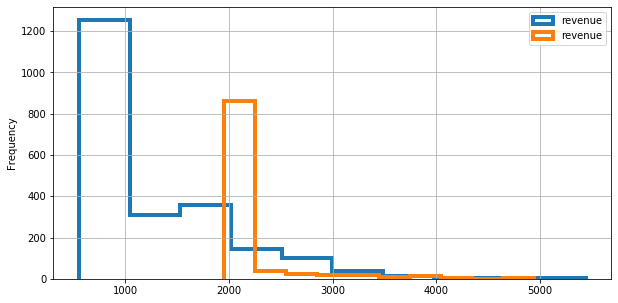

In [91]:
summary_of_users_short.query('tariff=="smart"')['revenue'].plot(kind='hist',histtype='step',linewidth=4,figsize=(10,5),legend=True)
summary_of_users_short.query('tariff=="ultra"')['revenue'].plot(kind='hist',histtype='step',linewidth=4,figsize=(10,5),grid=True,legend=True)

Получилось не наглядно, по гистограмме можно лишь судить, что клиентов тарифа "Смарт" больше чем "Ультра". И то, что выручка от клиентов СМАРТА в основном на уровне около 1000, а у клиентов "Ультра" в районе 2000. Посмотрим на объем вручки в целом.

In [92]:
print((summary_of_users_short.query('tariff=="smart"')['revenue'].sum()/summary_of_users_short['revenue'].sum()*100).round(1),'% от всего объема выручки составляю клиенты тарифа СМАРТ')
print('Клиентов тарифа СМАРТ в',(users_of_smart/users_of_ultra).round(1), 'больше, чем клиентов УЛЬТРА')

56.3 % от всего объема выручки составляю клиенты тарифа СМАРТ
Клиентов тарифа СМАРТ в 2.4 больше, чем клиентов УЛЬТРА


Клиенты тарифа УЛЬТРА очень важны для Мегалайн, т.к. это почти половина от выручки,при том, что их количество в 2.4 раза меньше, чем клиентов тарифа СМАРТ.

### Шаг 5. Общий вывод